

![](https://images.aicrowd.com/raw_images/challenges/banner_file/901/d5b56de544c949cb8bf7.jpg)


# 0. Installing aircrowd-cli and downloading Dataset


In [1]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/-cWKHaSfcGvfm5Utucg3oM7AMKCUdsRc017qs8UiKOI
API Key valid
Saved API Key successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c obstacle-prediction -o data

data.npz:   0%|          | 0.00/6.52M [00:00<?, ?B/s]

sample_submission.csv:   0%|          | 0.00/9.01k [00:00<?, ?B/s]

# 1. Importing Libraries

<h3>In this solution we will use XGB and CatBoost libraries to train the model and generate the predictions</h3>

In [11]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 21 kB/s 


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 2. Reading the dataset

<h3>Here, we will read the `data.npz` which contains both training samples & labels, and testing samples</h3>

In [5]:
data = np.load("/content/data/data.npz", allow_pickle=True)

train_data = data["train"]
test_data = data['test']

train_data.shape, test_data.shape

((5000, 2), (3000,))

In [ ]:
train_data[2][0].shape

(300, 4)

In [6]:
# Convert each training to 1D array so can we can put that into a sklearn model
X = np.array([sample.flatten() for sample in train_data[:, 0].tolist()])
y = np.array(train_data[:, 1].tolist())


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


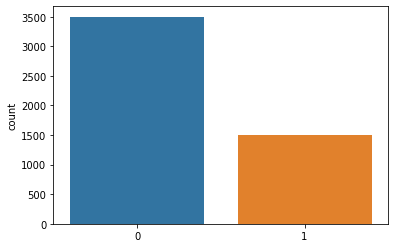

In [7]:
# Checking for any class imbalanceb
sns.countplot(y)

In [20]:
# Getting a random 3D lidar sample data
import random
INDEX = random.randint(0, train_data.shape[0])

# Getting the individual x,y and z points.
x = train_data[INDEX][0][:, 0].tolist()
y = train_data[INDEX][0][:, 1].tolist()
z = train_data[INDEX][0][:, 2].tolist()

# Label for the corrosponding sample ( is there an obstacle )
label  = train_data[INDEX][1]
obstacle = bool(label)
# Generating the 3D graph
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   marker=dict(
                                   size=1,       
                                   colorscale='Viridis',
                                   opacity=0.8))])
print("is obstacle presented : ", obstacle)
fig.show()



is obstacle presented :  True


# 3. Modeling
<h3>The strategy which seems to work best was to stack probability predictions of 5 XGB models and 5 CatBoost models and adjust threshhold for final prediction. Parameters for models were found using Optuna. </h3>

In [ ]:
seed = 73
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

models = []

for i, (train_index, valid_index) in enumerate(kf.split(X)):
    
    X_train, y_train = X[train_index], y[train_index]
    X_valid, y_valid = X[valid_index], y[valid_index]

    model = XGBClassifier(n_estimators=300,
                          learning_rate=0.293967999477144,
                          subsample=0.6198231912457959,
                          colsample_bytree=0.6392355971709197,
                          grow_policy='depthwise',
                          max_depth=10,
                          reg_lambda=20.320390675035057,
                          reg_alpha=1.1740272387059525,
                          min_child_weight=2)
    model.fit(X_train, y_train)
    models.append(model)

    cat_params = {'depth': 7, 
                  'learning_rate': 0.1089803195170146, 
                  'random_strength': 67, 
                  'bagging_temperature': 0.04199212199625898, 
                  'od_type': 'IncToDec'}
   
    model = CatBoostClassifier(
            iterations=1000,
            verbose=0,
            loss_function="Logloss",
            eval_metric="F1",
            l2_leaf_reg=50,
            random_seed=seed,
            border_count=64,
            **cat_params
        )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
    models.append(model)

    # model = RandomForestClassifier(max_depth=7, n_estimators=300)
    # model.fit(X_train, y_train)
    # models.append(model)

In [ ]:
# Converting each testing sample into 1D array
X_test = [sample.flatten() for sample in test_data.tolist()]

predictions = np.array([0. for i in range(len(X_test))])
for model in models:
    preds = model.predict_proba(X_test)
    predictions += np.array([pr[1] for pr in preds])
    
predictions = [1 if pr > 0.65 else 0 for pr in predictions]


## This solution put us on the 2nd place on private leaderboard on this puzzle with F1 score: 0.920 and accuracy: 0.934

## Submitting our Predictions to the system

In [ ]:
# Converting the predictions array into pandas dataset
submission = pd.DataFrame({"label":predictions})
# Saving the pandas dataframe
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"), index=False)

## 
**Note : Please save the notebook before submitting it (Ctrl + S)**

In [ ]:
!aicrowd notebook submit -c obstacle-prediction -a assets --no-verify